## New model to include neighborhood effects

v0.1 did not consider neighbors, so estimates were to specific to the source data used for modeling

v0.2 will consider value of wait time of neighbor points 

In [159]:
from datetime import date, datetime
from BorderModel import BorderImpute
from sklearn.ensemble import ExtraTreesRegressor
from dbhelper import pd_query

start = date(2014, 1, 1)
end = date(2014, 3, 1)
imputer = BorderImpute(start, end)

# Get source data with neighbor features
source_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=1
                   and valid = 1
                   and waittime is not null
                   and (minute = 0 or minute = 30)
                order by c.date;
               '''
dfsource = imputer.prepare_source(pd_query(source_query))

In [68]:
dfsource.head()

,year,month,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2007-01-01 00:30:00,2007,1,0,30,0.501538,4,0.3,NaN
2007-01-01 01:00:00,2007,1,0,60,1.364060,0,0.4,4.000000
2007-01-01 01:30:00,2007,1,0,90,2.665500,1,0.0,1.714286
2007-01-01 02:00:00,2007,1,0,120,2.100310,0,0.0,1.333333
2007-01-01 02:30:00,2007,1,0,150,1.197660,0,0.0,0.700000


In [160]:
from BorderModel import BorderImpute, xy_laglead

# Run model
model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, bootstrap=True, oob_score=True)
imputer.build_model(model)

In [161]:
print imputer.model_ll.oob_score_
print imputer.model_lead.oob_score_
print imputer.model_lag.oob_score_

0.859127057466
0.816254076415
0.819998902705


## OOB scores are better than model without lag/lead
Encouraging, but not clear yet whether this is a low bias / high variance situation

Need to test against holdout set with waittimes artificially set to zero

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
target_query = '''
               select 
                   c.date,
                   year,
                   month,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime
               from crossingdata c
               join datefeatures d
                   on d.date = c.date
               join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 2
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=5
                   and valid = 1
                   and waittime is not null
                   and (minute = 0 or minute = 30)
                order by c.date;
               '''

target_df = pd_query(target_query)

In [153]:
target_df.head()

,date,year,month,dayofweek,minofday,volume,waittime
0,2007-01-01 00:30:00,2007,1,0,30,1.92317,0
1,2007-01-01 01:00:00,2007,1,0,60,3.75655,0
2,2007-01-01 01:30:00,2007,1,0,90,4.68321,14
3,2007-01-01 02:00:00,2007,1,0,120,5.75827,22
4,2007-01-01 02:30:00,2007,1,0,150,5.76075,13


In [122]:
from BorderModel import emulate_testdata
dftest = emulate_testdata(target_df)

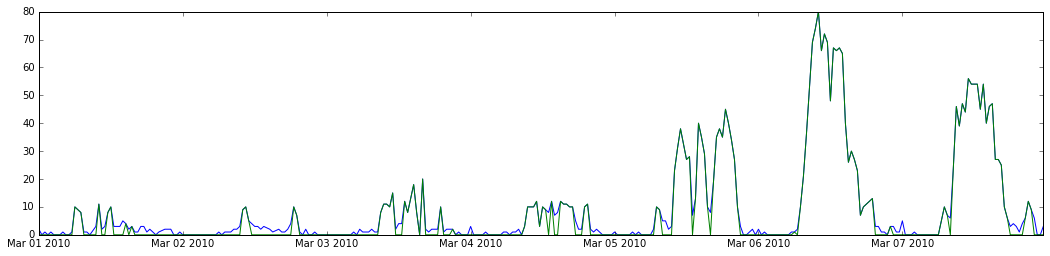

In [124]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime)
plt.plot(dftest[(dftest.date >= start) & (dftest.date < end)].set_index('date').waittime);

### Next steps
1. Create a dataframe with emulated zeros
2. Create a dataframe with nulls where waittime is zero
3. create_lead_lag
    * for first iteration, assume that all zeros are test data
    * i.e., set zero lag values to null
    * formally, any lag value that comes from a region of test data will be set to null
    * possible to use a dataframe where all test data has been masked to null to make this easier
4. create_neighbor_features 
5. predict on non-null values
6. Create a new dataframe using predictions to fill in gaps
7. Repeat 2 until all gaps are filled

In [135]:
dftestnull = dftest.copy()
dftestnull.waittime = dftestnull.waittime.apply(lambda x: None if x == 0 else x)

In [136]:
dftestnull.head(10)

,date,year,month,dayofweek,minofday,volume,waittime
0,2007-01-01 00:30:00,2007,1,0,30,1.923170,NaN
1,2007-01-01 01:00:00,2007,1,0,60,3.756550,NaN
2,2007-01-01 01:30:00,2007,1,0,90,4.683210,14
3,2007-01-01 02:00:00,2007,1,0,120,5.758270,22
4,2007-01-01 02:30:00,2007,1,0,150,5.760750,13
5,2007-01-01 03:00:00,2007,1,0,180,2.070420,NaN
6,2007-01-01 03:30:00,2007,1,0,210,1.096730,NaN
7,2007-01-01 04:00:00,2007,1,0,240,0.739786,NaN
8,2007-01-01 04:30:00,2007,1,0,270,0.541747,NaN
9,2007-01-01 05:00:00,2007,1,0,300,0.549100,NaN


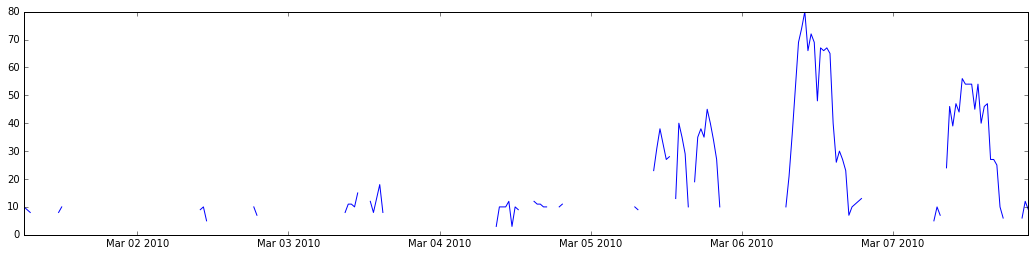

In [140]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(dftestnull[(dftestnull.date >= start) & (dftestnull.date < end)].set_index('date').waittime);

In [162]:
from BorderModel import BorderImpute
imputer.prepare_target(emulate_testdata(target_df)).head(20)

,year,month,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2007-01-01 00:30:00,2007,1,0,30,1.923170,NaN,16.500000,NaN
2007-01-01 01:00:00,2007,1,0,60,3.756550,NaN,14.900000,NaN
2007-01-01 01:30:00,2007,1,0,90,4.683210,14,14.333333,NaN
2007-01-01 02:00:00,2007,1,0,120,5.758270,22,7.857143,14.000000
2007-01-01 02:30:00,2007,1,0,150,5.760750,13,1.000000,18.571429
2007-01-01 03:00:00,2007,1,0,180,2.070420,1,NaN,16.222222
2007-01-01 03:30:00,2007,1,0,210,1.096730,NaN,NaN,10.100000
2007-01-01 04:00:00,2007,1,0,240,0.739786,NaN,NaN,8.500000
2007-01-01 04:30:00,2007,1,0,270,0.541747,NaN,NaN,5.000000


In [228]:
from BorderModel import BorderImpute
imputer.predictdf = imputer.targetdf.copy()
dftest = imputer.predictdf.copy()
dftest = dftest[pd.isnull(dftest[imputer.label])]
yhat = imputer.predict_once(dftest, lead=True, lag=True)

In [229]:
yhat.head()

date
2007-01-01 19:00:00    28.67
2007-01-01 19:30:00    27.10
2007-01-01 20:00:00    24.08
2007-01-01 21:30:00     6.29
2007-01-01 22:30:00     5.69
dtype: float64

In [231]:
imputer.predictdf.head(50)

,year,month,dayofweek,minofday,volume,waittime,lead,lag
date,,,,,,,,
2007-01-01 00:30:00,2007,1,0,30,1.923170,NaN,16.500000,NaN
2007-01-01 01:00:00,2007,1,0,60,3.756550,NaN,14.900000,NaN
2007-01-01 01:30:00,2007,1,0,90,4.683210,14.00,14.333333,NaN
2007-01-01 02:00:00,2007,1,0,120,5.758270,22.00,7.857143,14.000000
2007-01-01 02:30:00,2007,1,0,150,5.760750,13.00,1.000000,18.571429
2007-01-01 03:00:00,2007,1,0,180,2.070420,1.00,NaN,16.222222
2007-01-01 03:30:00,2007,1,0,210,1.096730,NaN,NaN,10.100000
2007-01-01 04:00:00,2007,1,0,240,0.739786,NaN,NaN,8.500000
2007-01-01 04:30:00,2007,1,0,270,0.541747,NaN,NaN,5.000000


In [261]:
from BorderModel import BorderImpute
imputer.predict()

34455
13612
3677
637
128
38
21
13
5
0


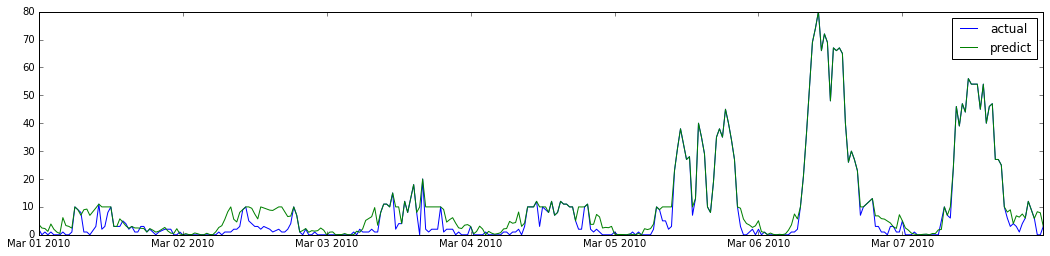

In [262]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

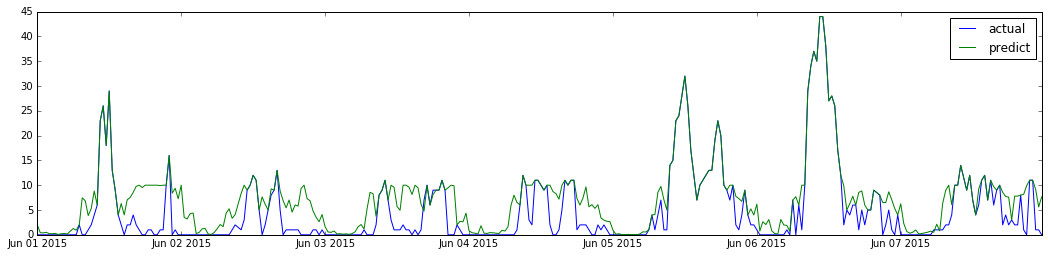

In [263]:
start = '2015-06-01'
end = '2015-06-08'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

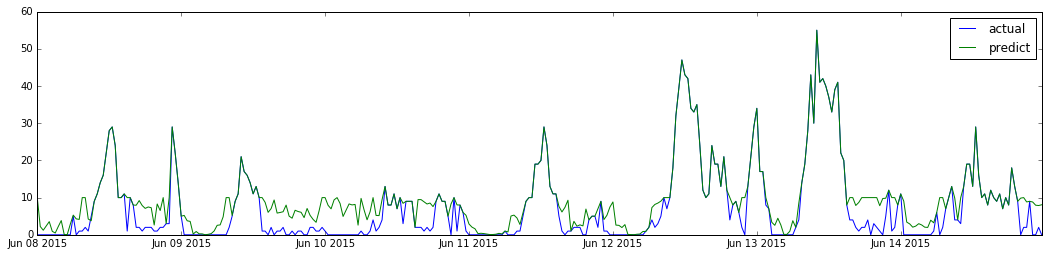

In [288]:
start = '2015-06-08'
end = '2015-06-15'
plt.figure(figsize=(18,4))
plt.plot(target_df[(target_df.date >= start) & (target_df.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

## Initial estimate looks reasonable.  Note that charts above compare against unsmoothed wait times.

In [265]:
query = '''
        select date, metric as waittime
        from mungedata
        where munger_id = 2
        and crossing_id = 5
        and is_waittime = true
        '''

smoothdf = pd_query(query)

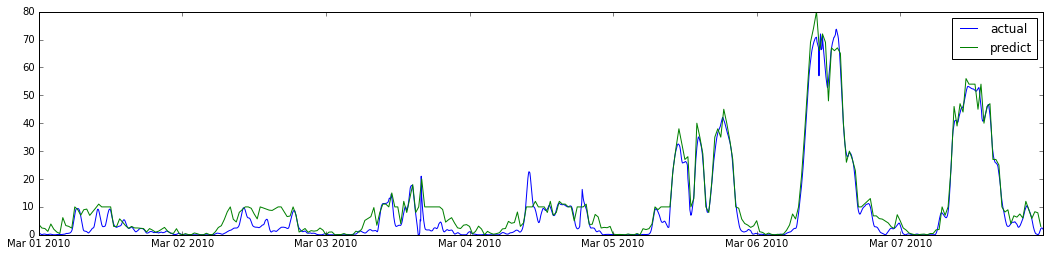

In [266]:
start = '2010-03-01'
end = '2010-03-08'
plt.figure(figsize=(18,4))
plt.plot(smoothdf[(smoothdf.date >= start) & (smoothdf.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

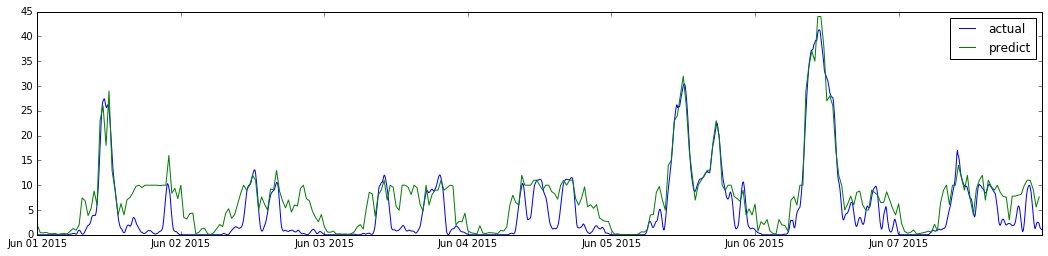

In [267]:
start = '2015-06-01'
end = '2015-06-08'
plt.figure(figsize=(18,4))
plt.plot(smoothdf[(smoothdf.date >= start) & (smoothdf.date < end)].set_index('date').waittime, label='actual')
plt.plot(imputer.predictdf[(imputer.predictdf.index >= start) & (imputer.predictdf.index < end)].waittime, label='predict')
plt.legend();

### Comparison with smoothed data is not very different.  Better approach is to estimate zeros at 5 minute grain, then smooth imputed data, then compare with smoothed actuals.

## For purposes of model evalution, just compare unsmoothed imputed vs actual.

In [287]:
from sklearn.metrics import r2_score

r2_score(target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)].waittime,
         imputer.predictdf[pd.isnull(imputer.targetdf.waittime)].waittime)

-6.8822396198532543

### Although predictions are better than v0.1, they are still overestimating value because neighbors always start above threshold.

## Look for a scaling factor that provides a better fit

In [290]:
predictdf = imputer.predictdf.copy()[pd.isnull(imputer.targetdf.waittime)]
actualdf = target_df.set_index('date')[pd.isnull(imputer.targetdf.waittime)]

from sklearn.metrics import mean_squared_error
def obj_func(x, a, b):
    return mean_squared_error(a, b * x[0])

In [291]:
from scipy.optimize import minimize

res = minimize(obj_func, .5, args=(actualdf.waittime, predictdf.waittime))

In [292]:
res

   status: 0
  success: True
     njev: 3
     nfev: 9
 hess_inv: array([[1]])
      fun: 1.7265280210260605
        x: array([ 0.25198228])
  message: 'Optimization terminated successfully.'
      jac: array([ -2.23517418e-07])
      nit: 1

In [296]:
r2_score(actualdf.waittime,
         predictdf.waittime * .25)

0.29269489368415758

## Better than naive estimate where zeros are set to a constant

In [303]:
actualdf.waittime.mean()

1.128267323605584

In [300]:
r2_score(actualdf.waittime, np.ones(len(predictdf.waittime)) * 1.13)

-1.2298075053873703e-06